In [1]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import torch
import requests
from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import platform
import statsmodels.api as sm
import ssl
import certifi
from urllib.request import urlopen
import json
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

print("CUDA 사용 가능:", torch.cuda.is_available())
print("cuDNN 사용 가능:", torch.backends.cudnn.is_available())
print("cuDNN 버전:", torch.backends.cudnn.version())
print("GPU 이름:", torch.cuda.get_device_name(0))

CUDA 사용 가능: True
cuDNN 사용 가능: True
cuDNN 버전: 90100
GPU 이름: NVIDIA GeForce RTX 3090


In [2]:
# 경고 무시 설정
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [3]:
matplotlib.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 날짜를 회계분기 말일로 정규화
def normalize_dates_to_quarter_end(df):
    df = df.copy()
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date']) + pd.offsets.QuarterEnd(0)
    df = df.set_index('date')
    return df

# long-format 변환 함수 (ticker는 컬럼에서 제거하고 별도 컬럼으로 분리)
def reshape_margin_df_for_db(margin_df):
    melted_df = margin_df.reset_index().melt(id_vars=['date', 'ticker'], var_name='accounting_item', value_name='value')
    final_df = melted_df.dropna().sort_values(['accounting_item', 'ticker', 'date'])
    return final_df

# 마진 및 성장률 시계열 데이터 수집 및 long-format 변환
def get_margin_time_series(ticker_list, apikey):
    result_df_list = []

    for ticker in tqdm(ticker_list, desc="Fetching income statements"):
        url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?period=quarter&limit=100&apikey={apikey}"
        response = requests.get(url)
        if response.status_code != 200:
            print(f"❌ {ticker} API 요청 실패: {response.status_code}")
            continue

        data = response.json()
        df = pd.DataFrame(data)
        if df.empty:
            print(f"❌ {ticker} 수신 데이터 없음.")
            continue

        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)

        # 기본 컬럼 정의
        df['revenue'] = df['revenue']
        df['grossProfit'] = df['grossProfit']
        df['operatingIncome'] = df['operatingIncome']
        df['netIncome'] = df['netIncome']

        # 마진율 계산
        df['GPM'] = df['grossProfit'] / df['revenue']
        df['OPM'] = df['operatingIncome'] / df['revenue']
        df['NPM'] = df['netIncome'] / df['revenue']

        # 성장률 계산
        for col in ['revenue', 'grossProfit', 'operatingIncome', 'netIncome']:
            df[f'{col}_qoq'] = df[col].pct_change(periods=1)
            df[f'{col}_yoy'] = df[col].pct_change(periods=4)

        # 필요한 항목만 추출
        keep_cols = ['revenue', 'grossProfit', 'operatingIncome', 'netIncome', 
                     'GPM', 'OPM', 'NPM',
                     'revenue_qoq', 'grossProfit_qoq', 'operatingIncome_qoq', 'netIncome_qoq',
                     'revenue_yoy', 'grossProfit_yoy', 'operatingIncome_yoy', 'netIncome_yoy']

        sub_df = df[keep_cols]
        sub_df = normalize_dates_to_quarter_end(sub_df)
        sub_df['ticker'] = ticker

        result_df_list.append(sub_df)

    # 전체 병합 및 정렬
    if not result_df_list:
        return pd.DataFrame()

    full_df = pd.concat(result_df_list)
    full_df = full_df.replace([np.inf, -np.inf], np.nan)
    full_df = full_df.sort_index()

    return full_df


def load_forecast_by_hscode(db_info, root_hs_code, table_name='trade_forecast_by_month'):
    """
    특정 root_hs_code에 해당하는 예측 데이터를 데이터베이스에서 불러오는 함수

    Parameters:
    - db_info (dict): DB 접속 정보 (host, port, user, password, database)
    - root_hs_code (str or int): 조회할 HS 코드
    - table_name (str): 테이블 이름 (기본값: 'trade_forecast_by_month')

    Returns:
    - pd.DataFrame: 조회된 데이터프레임
    """
    try:
        # ✅ DB 엔진 생성
        engine = create_engine(
            f"mysql+pymysql://{db_info['user']}:{db_info['password']}@{db_info['host']}:{db_info['port']}/{db_info['database']}"
        )

        # ✅ SQL 쿼리 작성 및 실행
        query = f"""
            SELECT *
            FROM {table_name}
            WHERE root_hs_code = '{root_hs_code}'
            ORDER BY period
        """
        df = pd.read_sql(query, con=engine)

        print(f"✅ root_hs_code={root_hs_code}에 해당하는 {len(df)}개 행을 불러왔습니다.")
        return df
    
    except Exception as e:
        print(f"❌ 데이터 불러오기 실패: {e}")
        return pd.DataFrame()
    
    
def get_quarterly_export_forecast(db_info: dict, hs_code: str) -> pd.DataFrame:
    """
    특정 HS 코드를 기준으로 수출 예측 데이터를 불러와 분기별로 정리하는 함수

    Parameters:
    - db_info: dict, MariaDB 접속 정보
    - hs_code: str, 예: '854232' (HS 코드)

    Returns:
    - quarterly_sum_df: DataFrame, 분기별 수출합계 및 qoq/yoy 증가율 포함
    """
    # DB에서 해당 HS코드의 예측 데이터 로드
    target_export_df = load_forecast_by_hscode(db_info, hs_code)
    target_export_df = target_export_df.drop_duplicates(subset=['period'])

    # datetime 변환
    target_export_df['period'] = pd.to_datetime(target_export_df['period'])

    # 분기 추출 및 그룹화
    target_export_df['quarter'] = target_export_df['period'].dt.to_period('Q')
    quarterly_sum_df = target_export_df.groupby('quarter')['expDlr_forecast_12m'].sum().reset_index()

    # datetime 정렬 및 추가 계산
    quarterly_sum_df['quarter'] = quarterly_sum_df['quarter'].dt.to_timestamp()
    quarterly_sum_df['export_qoq_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=1)
    quarterly_sum_df['export_yoy_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=4)
    quarterly_sum_df['date_month'] = quarterly_sum_df['quarter'] + pd.offsets.QuarterEnd(0)

    return quarterly_sum_df

def run_lstm_forecast_and_plot(long_df, ticker, item, input_window=12, output_window=4, epochs=200):
    # ✔️ 데이터 준비
    df = long_df[(long_df['accounting_item'] == item) & (long_df['ticker'] == ticker)].copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # ✔️ 정규화
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[['value']].values)

    # ✔️ Dataset 클래스
    class TimeSeriesDataset(Dataset):
        def __init__(self, series, input_window, output_window):
            self.series = series
            self.input_window = input_window
            self.output_window = output_window

        def __len__(self):
            return len(self.series) - self.input_window - self.output_window + 1

        def __getitem__(self, idx):
            x = self.series[idx : idx + self.input_window]
            y = self.series[idx + self.input_window : idx + self.input_window + self.output_window]
            return torch.FloatTensor(x), torch.FloatTensor(y).squeeze()

    dataset = TimeSeriesDataset(scaled_values, input_window, output_window)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # ✔️ LSTM 모델
    class LSTMForecast(nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=2):
            super(LSTMForecast, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.linear = nn.Linear(hidden_size, output_window)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.linear(out[:, -1, :])
            return out

    # ✔️ GPU 및 모델
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMForecast().to(device)

    # ✔️ 학습 루프
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss:.6f}")

    # ✔️ 예측
    model.eval()
    last_sequence = torch.FloatTensor(scaled_values[-input_window:]).reshape(1, -1, 1).to(device)
    with torch.no_grad():
        prediction = model(last_sequence).cpu().numpy()

    # ✔️ 역정규화 및 시각화
    predicted = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()
    past = df['value'].values
    dates = df['date']
    future_dates = pd.date_range(dates.iloc[-1] + pd.offsets.QuarterEnd(), periods=output_window, freq='QE-DEC')

    plt.figure(figsize=(12, 5))
    plt.plot(dates, past, label='Actual')
    plt.plot(future_dates, predicted, label='Predicted', marker='o')
    plt.title(f'{ticker} - {item} LSTM Forecast')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 결과 반환도 가능
    return pd.Series(predicted, index=future_dates, name='forecasted_value')

def forecast_fundamental_lstm(df, ticker, item, input_window=12, output_window=4, epochs=200, hidden_size=64):
    # ✅ 1. 데이터 필터링 및 정렬
    df_opm = df[(df['accounting_item'] == item ) & (df['ticker'] == ticker)].copy()
    df_opm['date'] = pd.to_datetime(df_opm['date'])
    df_opm = df_opm.sort_values('date').reset_index(drop=True)

    if len(df_opm) < input_window + output_window:
        raise ValueError(f"❌ Not enough data for ticker {ticker}")

    # ✅ 2. 정규화
    scaler = MinMaxScaler()
    scaled_opm = scaler.fit_transform(df_opm[['value']].values)

    # ✅ 3. Dataset 정의
    class TimeSeriesDataset(Dataset):
        def __init__(self, series, input_window, output_window):
            self.series = series
            self.input_window = input_window
            self.output_window = output_window

        def __len__(self):
            return len(self.series) - self.input_window - self.output_window + 1

        def __getitem__(self, idx):
            x = self.series[idx:idx + self.input_window]
            y = self.series[idx + self.input_window:idx + self.input_window + self.output_window]
            return torch.FloatTensor(x), torch.FloatTensor(y).squeeze()

    dataset = TimeSeriesDataset(scaled_opm, input_window, output_window)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # ✅ 4. LSTM 모델 정의
    class LSTMForecast(nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=2):
            super(LSTMForecast, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.linear = nn.Linear(hidden_size, output_window)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.linear(out[:, -1, :])
            return out

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMForecast(hidden_size=hidden_size).to(device)

    # ✅ 5. 학습
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        for x, y in dataloader:
            x = x.to(device)  # shape: (batch, seq_len, 1)
            x = x.view(x.size(0), x.size(1), 1)
            y = y.to(device)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

    # ✅ 6. 예측 수행
    model.eval()
    last_seq = torch.FloatTensor(scaled_opm[-input_window:]).reshape(1, -1, 1).to(device)
    with torch.no_grad():
        prediction = model(last_seq).cpu().numpy()

    predicted_opm = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()

    # ✅ 7. 기존 + 예측 결합
    past = df_opm['value'].values
    dates = df_opm['date']
    future_dates = pd.date_range(dates.iloc[-1] + pd.offsets.QuarterEnd(), periods=output_window, freq='QE-DEC')

    historical_df = pd.DataFrame({'date': dates, item : past, 'type': 'actual'})
    forecast_df = pd.DataFrame({'date': future_dates, item : predicted_opm, 'type': 'forecast'})
    combined_df = pd.concat([historical_df, forecast_df], ignore_index=True)
    combined_df = combined_df.sort_values('date').reset_index(drop=True)
    combined_df['ticker'] = ticker

    return combined_df

def average_forecast_fundamental_lstm(df, ticker, item, input_window=12, output_window=4, epochs=200, hidden_size=64, n_runs=10):
    forecasts = []

    for _ in tqdm(range(n_runs), desc=f"Forecasting {ticker}-{item}"):
        result_df = forecast_fundamental_lstm(df, ticker, item, input_window, output_window, epochs, hidden_size)
        forecast_values = result_df[result_df['type'] == 'forecast'][item].values
        forecasts.append(forecast_values)

    forecast_array = np.array(forecasts)
    mean_forecast = forecast_array.mean(axis=0)
    std_forecast = forecast_array.std(axis=0)

    future_dates = pd.date_range(
        df[(df['accounting_item'] == item) & (df['ticker'] == ticker)]['date'].max() + pd.offsets.QuarterEnd(),
        periods=output_window,
        freq='QE-DEC'
    )

    summary_df = pd.DataFrame({
        'date': future_dates,
        'mean_forecast': mean_forecast,
        'lower_bound': mean_forecast - std_forecast,
        'upper_bound': mean_forecast + std_forecast,
        'ticker': ticker
    })

    return summary_df


def fit_sarimax_with_exog_gridsearch_model(long_df, ticker, item, export_df, steps=4, pdq_range=(0, 2), seasonal_pdq_range=(0, 2), seasonal_period=4):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from itertools import product

    df_filtered = long_df[(long_df['ticker'] == ticker) & (long_df['accounting_item'] == item)].copy()
    df_filtered = df_filtered[['date', 'value']].rename(columns={'value': item})
    df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()]
    ts = df_filtered.set_index('date')[item].astype(float)

    export_df_renamed = export_df.rename(columns={'date_month': 'date'})
    export_df_renamed = export_df_renamed.loc[:, ~export_df_renamed.columns.duplicated()]

    merged_df = pd.merge(df_filtered, export_df_renamed[['date', 'export_yoy_change']], on='date', how='inner').sort_values('date')
    exog = merged_df.set_index('date')[['export_yoy_change']].astype(float)
    exog = exog.replace([np.inf, -np.inf], np.nan).dropna()

    common_index = ts.index.intersection(exog.index)
    ts = ts.loc[common_index].sort_index()
    exog = exog.loc[common_index].sort_index()

    export_df = export_df.sort_values(by='date_month').reset_index(drop=True)
    future_exog_df = export_df[export_df['date_month'] > ts.index[-1]][['export_yoy_change']].head(steps)
    future_exog_df = future_exog_df.replace([np.inf, -np.inf], np.nan).dropna()

    if len(future_exog_df) < steps:
        print(f"❌ 미래 외생변수 부족: {len(future_exog_df)}개 → {steps}개 필요")
        return None

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    p = d = q = range(*pdq_range)
    P = D = Q = range(*seasonal_pdq_range)
    s = seasonal_period

    for order in product(p, d, q):
        for seasonal_order in product(P, D, Q):
            seasonal_order_full = (*seasonal_order, s)
            try:
                model = SARIMAX(ts, exog=exog, order=order, seasonal_order=seasonal_order_full,
                                enforce_stationarity=False, enforce_invertibility=False)
                result = model.fit(disp=False)
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = order
                    best_seasonal_order = seasonal_order_full
                    best_model = result
            except Exception as e:
                print(f"❌ 실패: order={order}, seasonal_order={seasonal_order_full} → {str(e)}")

    if best_model is None:
        print("❌ SARIMAX 모델 최적화 실패")
        return None

    forecast_result = best_model.get_forecast(steps=steps, exog=future_exog_df)
    pred_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()
    future_index = pd.date_range(start=ts.index[-1] + pd.offsets.QuarterEnd(1), periods=steps, freq='Q')

    forecast_df = pd.DataFrame({
        'forecast': pred_mean.values,
        'lower': conf_int.iloc[:, 0].values,
        'upper': conf_int.iloc[:, 1].values
    }, index=future_index)

    print(f"✅ 최적 모델: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")
    return forecast_df


def fit_sarimax_with_no_exog_gridsearch_model(long_df, ticker, item='revenue_yoy', steps=4,
                                  pdq_range=(0, 2), seasonal_pdq_range=(0, 2), seasonal_period=4):
    """
    long_df에서 특정 ticker와 item을 선택하여 SARIMA 예측을 수행하는 함수

    Parameters:
    - long_df: DataFrame, columns = ['ticker', 'accounting_item', 'date', 'value']
    - ticker: str, 기업 코드
    - item: str, 회계 항목명
    - steps: int, 예측 기간
    - pdq_range: tuple, SARIMA(p,d,q) 범위 (e.g. (0, 2) → 0~1)
    - seasonal_pdq_range: tuple, 계절성 SARIMA(P,D,Q) 범위
    - seasonal_period: int, 계절 주기 (예: 4분기 → 4)

    Returns:
    - forecast_df: DataFrame, 예측값 및 신뢰구간 포함
    """

    # 1. 시계열 추출
    df_filtered = long_df[
        (long_df["ticker"] == ticker) &
        (long_df["accounting_item"] == item)
    ][["date", "value"]].rename(columns={"value": item}).copy()

    # 2. 시계열 인덱스 설정
    ts = df_filtered.set_index("date")[item].astype(float).sort_index()

    # ✅ 중복 인덱스 제거
    ts = ts[~ts.index.duplicated(keep='last')]

    # ✅ 빈도 명시 (경고 제거)
    ts = ts.asfreq('Q-DEC')  # 또는 'Q'

    # 3. SARIMA 그리드 서치
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    p = d = q = range(*pdq_range)
    P = D = Q = range(*seasonal_pdq_range)
    s = seasonal_period

    for order in product(p, d, q):
        for seasonal_order in product(P, D, Q):
            seasonal_order_full = (*seasonal_order, s)
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model = SARIMAX(ts, order=order, seasonal_order=seasonal_order_full,
                                    enforce_stationarity=False, enforce_invertibility=False)
                    result = model.fit(disp=False)

                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = order
                    best_seasonal_order = seasonal_order_full
                    best_model = result

            except Exception as e:
                print(f"❌ 실패: order={order}, seasonal_order={seasonal_order_full} → {str(e)}")

    # 4. 예측 수행
    if best_model is None:
        print("❌ SARIMA 모델 최적화 실패")
        return None

    future_index = pd.date_range(start=ts.index[-1] + pd.offsets.QuarterEnd(1), periods=steps, freq='Q')
    forecast_result = best_model.get_forecast(steps=steps)
    pred_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()

    forecast_df = pd.DataFrame({
        "forecast": pred_mean.values,
        "lower": conf_int.iloc[:, 0].values,
        "upper": conf_int.iloc[:, 1].values
    }, index=future_index)

    print(f"✅ 최적 모델: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")
    return forecast_df


def get_yoy_based_forecast_amounts(long_df, forecast_df, ticker, accounting_item_raw, accounting_item_yoy):
    """
    예측된 YoY 성장률을 이용해 미래 매출 또는 영업이익 수준(raw value)을 예측합니다.

    Parameters:
    - long_df: 원본 데이터프레임
    - forecast_df: SARIMA 예측 결과 (forecast 컬럼 포함)
    - ticker: 기업 코드 (예: 'MU')
    - accounting_item_raw: 원시 항목 (예: 'revenue')
    - accounting_item_yoy: YOY 항목 (예: 'revenue_yoy')

    Returns:
    - forecast_amount_df: 예측된 금액 (raw value) DataFrame
    """

    # ✅ 전년도 해당 분기 값 가져오기 (t-4, t-3, t-2, t-1)
    raw_df = long_df[
        (long_df["ticker"] == ticker) & 
        (long_df["accounting_item"] == accounting_item_raw)
    ][["date", "value"]].copy()
    raw_df["date"] = pd.to_datetime(raw_df["date"])
    raw_df = raw_df.set_index("date").sort_index()
    raw_df = raw_df[~raw_df.index.duplicated(keep='last')]

    # ✅ 예측 대상 분기 리스트
    forecast_dates = forecast_df.index

    # ✅ 기준이 되는 전년도 매출값 추출
    reference_dates = [date - pd.DateOffset(years=1) for date in forecast_dates]
    reference_values = raw_df.loc[reference_dates]["value"].values

    # ✅ forecast된 YoY 성장률 적용
    forecast_yoy = forecast_df["forecast"].values
    forecast_values = reference_values * (1 + forecast_yoy)

    forecast_amount_df = pd.DataFrame({
        "forecasted_amount": forecast_values
    }, index=forecast_dates)

    return forecast_amount_df


def apply_growth_to_amount(base_amount_df, growth_df):
    """
    base_amount_df의 forecasted_amount에 대해, growth_df의 YoY 성장률을 곱해서 최종 예측값 생성

    Parameters:
    - base_amount_df: DataFrame, index = 날짜, column = 'forecasted_amount'
    - growth_df: DataFrame, index = 동일한 날짜, column = 'forecast' (비율형 성장률)

    Returns:
    - adjusted_df: DataFrame, column = 'adjusted_amount'
    """
    combined = pd.merge(
        base_amount_df,
        growth_df[["forecast"]],
        left_index=True,
        right_index=True,
        how="inner"
    )

    combined["adjusted_amount"] = combined["forecasted_amount"] * (1 + combined["forecast"])
    return combined[["adjusted_amount"]]

def measure_correl_lstm(long_df, export_df, accounting_item_target, ticker):
    """
    long_df와 export_df를 병합하여 특정 기업의 타겟 회계 항목과 수출 증가율 간의 상관계수를 측정합니다.
    """
    # 1. 회계 항목 필터링 및 정렬
    filtered_df = long_df[long_df['accounting_item'] == accounting_item_target].copy()
    filtered_df = filtered_df.sort_values(by='date')

    # 2. 날짜 컬럼 통일
    export_df = export_df.rename(columns={'date_month': 'date'})

    # 3. 날짜 기준 병합
    merged_df = pd.merge(filtered_df, export_df[['date', 'export_yoy_change']], on='date', how='inner')
    merged_df = merged_df[['date', 'ticker', 'value', 'export_yoy_change']]
    merged_df = merged_df.rename(columns={'value': accounting_item_target})

    # 4. 특정 기업 추출 및 정제
    target_df = merged_df[merged_df['ticker'] == ticker][[accounting_item_target, 'export_yoy_change']]
    target_df = target_df.replace([np.inf, -np.inf], np.nan).dropna()

    # 5. 상관계수 계산
    correlation = target_df[accounting_item_target].corr(target_df['export_yoy_change'])
    return correlation

In [5]:
apikey = 'hT0gAk87j9xZx4PlBApvBqfVL5IahvgV'

tickers = ['MU', 'AMAT', 'AVGO', 'LRCX', 'KLAC', 'ASML', 'COHR', 'UCTT', 'ICHR', 'ONTO', 'FORM', 'TER']
wide_df = get_margin_time_series(tickers, apikey)
long_df = reshape_margin_df_for_db(wide_df)

print(long_df.head())

Fetching income statements: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

           date ticker accounting_item     value
4370 2000-09-30   AMAT             GPM  0.509476
4381 2000-12-31   AMAT             GPM  0.516720
4385 2001-03-31   AMAT             GPM  0.483548
4392 2001-06-30   AMAT             GPM  0.447762
4404 2001-09-30   AMAT             GPM  0.399613


In [6]:
long_df['accounting_item'].unique().tolist()

['GPM',
 'NPM',
 'OPM',
 'grossProfit',
 'grossProfit_qoq',
 'grossProfit_yoy',
 'netIncome',
 'netIncome_qoq',
 'netIncome_yoy',
 'operatingIncome',
 'operatingIncome_qoq',
 'operatingIncome_yoy',
 'revenue',
 'revenue_qoq',
 'revenue_yoy']

In [8]:
db_info = {
    'host' : '192.168.0.230',
    'port' : 3307,
    'user' : 'stox7412',
    'password' : 'Apt106503!~',
    'database' : 'investar'
}

quarterly_sum_df = get_quarterly_export_forecast(db_info, '854232')
# 결과 확인
print(quarterly_sum_df)

✅ root_hs_code=854232에 해당하는 904개 행을 불러왔습니다.
      quarter  expDlr_forecast_12m  export_qoq_change  export_yoy_change  \
0  2007-01-01         0.000000e+00                NaN                NaN   
1  2007-04-01         0.000000e+00                NaN                NaN   
2  2007-07-01         0.000000e+00                NaN                NaN   
3  2007-10-01         0.000000e+00                NaN                NaN   
4  2008-01-01         3.383904e+09                inf                inf   
..        ...                  ...                ...                ...   
73 2025-04-01         2.002932e+10           0.237416           0.133763   
74 2025-07-01         2.102303e+10           0.049613           0.120286   
75 2025-10-01         2.028235e+10          -0.035232           0.008648   
76 2026-01-01         1.699342e+10          -0.162157           0.049857   
77 2026-04-01         5.685559e+09          -0.665426          -0.716138   

   date_month  
0  2007-03-31  
1  2007-06-

Epoch 0: Loss = 0.186994
Epoch 20: Loss = 0.081559
Epoch 40: Loss = 0.098058
Epoch 60: Loss = 0.077391
Epoch 80: Loss = 0.027356
Epoch 100: Loss = 0.017885
Epoch 120: Loss = 0.016422
Epoch 140: Loss = 0.011118
Epoch 160: Loss = 0.017877
Epoch 180: Loss = 0.014603


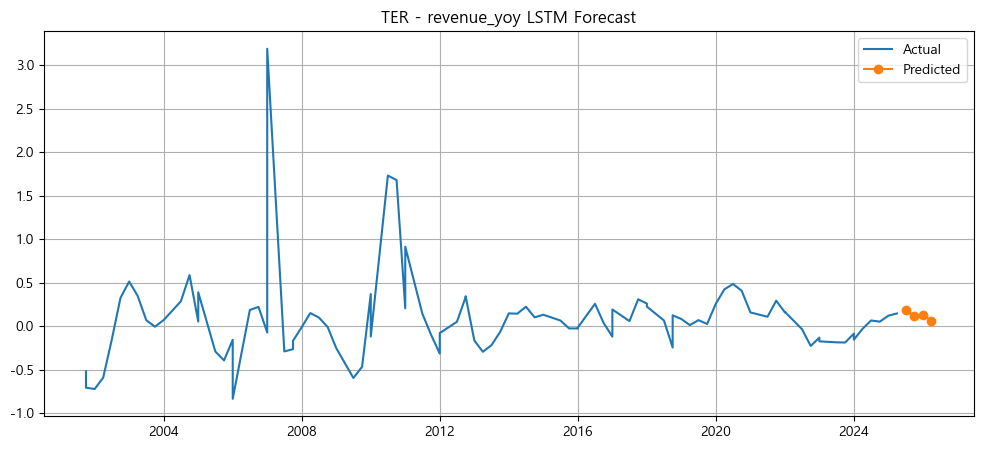

2025-06-30    0.187127
2025-09-30    0.118175
2025-12-31    0.133033
2026-03-31    0.061764
Freq: QE-DEC, Name: forecasted_value, dtype: float32

In [9]:
run_lstm_forecast_and_plot(long_df, ticker='TER', item='revenue_yoy', input_window=12, output_window=4, epochs=200)

In [55]:
# 사용 예시: MU 기업의 매출 증가율(revenue_yoy)을 기반으로 향후 4분기 예측
result_df = forecast_fundamental_lstm(
    df=long_df,
    ticker='MU',
    item='revenue_yoy',
    input_window=12,       # 과거 12분기 사용
    output_window=4,       # 향후 4분기 예측
    epochs=300,            # 에폭 수
    hidden_size=128        # LSTM hidden unit 크기
)

# 결과 확인
print(result_df.tail(6))

         date  revenue_yoy      type ticker
94 2024-12-31     0.842785    actual     MU
95 2025-03-31     0.382727    actual     MU
96 2025-06-30     0.381581  forecast     MU
97 2025-09-30     0.253116  forecast     MU
98 2025-12-31     0.153587  forecast     MU
99 2026-03-31     0.141842  forecast     MU


In [45]:
simulatedd_df = average_forecast_fundamental_lstm(long_df, 'KLAC', 'revenue_yoy', input_window=12, output_window=4, epochs=200, hidden_size=64, n_runs=30)
simulatedd_df

Forecasting KLAC-revenue_yoy: 100%|██████████| 30/30 [01:32<00:00,  3.08s/it]


,date,mean_forecast,lower_bound,upper_bound,ticker
0,2025-06-30,0.245374,0.187824,0.302924,KLAC
1,2025-09-30,0.152245,0.084832,0.219658,KLAC
2,2025-12-31,0.062924,-0.025927,0.151775,KLAC
3,2026-03-31,0.009171,-0.085993,0.104334,KLAC


#### 외생변수와 상관계수 측정

In [46]:
correlation = measure_correl_lstm(
    long_df=long_df,
    export_df=quarterly_sum_df,
    accounting_item_target='revenue_yoy',
    ticker='ASML'
)
print(f"revenue_yoy와 수출 YoY의 상관계수: {correlation:.4f}")

revenue_yoy와 수출 YoY의 상관계수: 0.5041


In [47]:
# 파라미터 설정
ticker = 'KLAC'
item = 'revenue_yoy'
steps = 4  # 예측할 분기 수

# 함수 실행
forecast_df_exog = fit_sarimax_with_exog_gridsearch_model(
    long_df=long_df,
    ticker=ticker,
    item=item,
    export_df=quarterly_sum_df,
    steps=steps
)

# 결과 출력
print(forecast_df_exog)

C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Programs\Python

✅ 최적 모델: order=(1, 0, 1), seasonal_order=(0, 0, 1, 4), AIC=-76.22
            forecast     lower     upper
2025-06-30  0.235659  0.008137  0.463181
2025-09-30  0.165442 -0.133931  0.464815
2025-12-31  0.108835 -0.231257  0.448926
2026-03-31  0.048739 -0.316734  0.414213


C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Temp\ipykernel_

In [59]:
forecast_df_noexog = fit_sarimax_with_no_exog_gridsearch_model(long_df, ticker=ticker, item='NPM', steps=4)
print(forecast_df_noexog)

C:\Users\82108\AppData\Local\Temp\ipykernel_6832\2571259211.py:441: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  ts = ts.asfreq('Q-DEC')  # 또는 'Q'


✅ 최적 모델: order=(1, 1, 1), seasonal_order=(1, 0, 0, 4), AIC=-82.06
            forecast     lower     upper
2025-06-30  0.316065  0.024984  0.607146
2025-09-30  0.300044 -0.022180  0.622269
2025-12-31  0.293478 -0.037563  0.624518
2026-03-31  0.290862 -0.044007  0.625730


C:\Users\82108\AppData\Local\Temp\ipykernel_6832\2571259211.py:477: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_index = pd.date_range(start=ts.index[-1] + pd.offsets.QuarterEnd(1), periods=steps, freq='Q')


In [60]:
forecast_amount_df = get_yoy_based_forecast_amounts(
    long_df=long_df,
    forecast_df = forecast_df_exog,
    ticker= ticker,
    accounting_item_raw='netIncome',
    accounting_item_yoy='NPM'
)

print(forecast_amount_df)


# # 함수 실행
# adjusted_df = apply_growth_to_amount(forecast_amount_df, forecast_df_noexog)
# adjusted_df

            forecasted_amount
2025-06-30       1.033562e+09
2025-09-30       1.102334e+09
2025-12-31       9.142642e+08
2026-03-31       1.141465e+09


In [26]:
long_df

,date,ticker,accounting_item,value
4370,2000-09-30,AMAT,GPM,0.509476
4381,2000-12-31,AMAT,GPM,0.516720
4385,2001-03-31,AMAT,GPM,0.483548
4392,2001-06-30,AMAT,GPM,0.447762
4404,2001-09-30,AMAT,GPM,0.399613
...,...,...,...,...
13020,2024-03-31,UCTT,revenue_yoy,0.102469
13032,2024-06-30,UCTT,revenue_yoy,0.224437
13046,2024-09-30,UCTT,revenue_yoy,0.242299
13058,2024-12-31,UCTT,revenue_yoy,0.266412


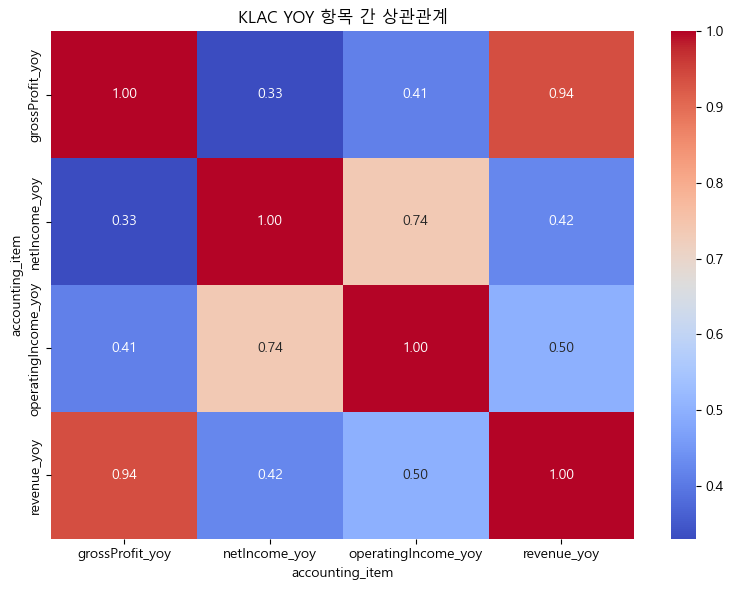

In [44]:
import seaborn as sns
ticker_list = ['MU', 'AMAT', 'AVGO', 'LRCX', 'KLAC', 'ASML', 'COHR', 'UCTT', 'ICHR', 'ONTO', 'FORM', 'TER']

def plot_yoy_correlation_for_ticker(long_df, ticker):
    # 1. YOY 항목 필터링 + ticker 선택
    yoy_df = long_df[
        (long_df['accounting_item'].str.endswith('_yoy')) &
        (long_df['ticker'] == ticker)
    ]

    # ✅ 2. 피벗: 중복 데이터가 있을 수 있으므로 pivot_table 사용
    pivot_df = yoy_df.pivot_table(
        index='date',
        columns='accounting_item',
        values='value',
        aggfunc='mean'   # 중복값은 평균으로 처리
    )

    # 3. 상관계수 계산
    correlation_df = pivot_df.corr()

    # 4. 히트맵 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{ticker} YOY 항목 간 상관관계")
    plt.tight_layout()
    plt.show()

# 사용 예시
plot_yoy_correlation_for_ticker(long_df, 'KLAC')

In [58]:
# 사용 예시: MU 기업의 매출 증가율(revenue_yoy)을 기반으로 향후 4분기 예측
result_df = forecast_fundamental_lstm(
    df=long_df,
    ticker= 'KLAC',
    item= 'NPM',
    input_window=12,       # 과거 12분기 사용
    output_window=4,       # 향후 4분기 예측
    epochs=300,            # 에폭 수
    hidden_size=128        # LSTM hidden unit 크기
)

# 결과 확인
print(result_df.tail(6))

          date       NPM      type ticker
98  2024-12-31  0.267978    actual   KLAC
99  2025-03-31  0.355340    actual   KLAC
100 2025-06-30  0.304652  forecast   KLAC
101 2025-09-30  0.356847  forecast   KLAC
102 2025-12-31  0.325236  forecast   KLAC
103 2026-03-31  0.287686  forecast   KLAC


In [54]:
long_df[long_df['ticker'] == 'KLAC']

,date,ticker,accounting_item,value
4360,2000-06-30,KLAC,GPM,0.570701
4368,2000-09-30,KLAC,GPM,0.573363
4379,2000-12-31,KLAC,GPM,0.573452
4387,2001-03-31,KLAC,GPM,0.541041
4390,2001-06-30,KLAC,GPM,0.525065
...,...,...,...,...
13024,2024-03-31,KLAC,revenue_yoy,-0.031742
13034,2024-06-30,KLAC,revenue_yoy,0.089632
13048,2024-09-30,KLAC,revenue_yoy,0.185479
13056,2024-12-31,KLAC,revenue_yoy,0.237310


In [ ]:
## 추후 연구용 

# ## ---------- 함수 정의 ----------
# 
# def preprocess_for_lstm(long_df, export_df, accounting_item_target):
#     filtered_df = long_df[long_df['accounting_item'] == accounting_item_target].copy()
#     filtered_df = filtered_df.sort_values(by='date')
#     export_df = export_df.rename(columns={'date_month': 'date'})
#     merged_df = pd.merge(filtered_df, export_df[['date', 'export_yoy_change']], on='date', how='inner')
#     merged_df = merged_df[['date', 'ticker', 'value', 'export_yoy_change']]
#     merged_df = merged_df.rename(columns={'value': accounting_item_target})
#     return merged_df
# 
# def create_lstm_dataset(df, target_col, exog_col, time_step):
#     values = df[[target_col, exog_col]].values
#     X, y = [], []
#     for i in range(len(values) - time_step):
#         x_i = values[i:i+time_step]
#         y_i = values[i+time_step, 0]
#         X.append(x_i)
#         y.append(y_i)
#     return np.array(X), np.array(y)
# 
# def build_lstm_model(input_shape):
#     model = Sequential([
#         Input(shape=input_shape),
#         LSTM(50, activation='relu'),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     return model
# 
# # ---------- 사용자 정의 ----------
# 
# ticker = 'MU'  # 예측할 기업 티커
# accounting_item_target = 'revenue_yoy'  # 예측 대상 항목
# time_step = 4
# 
# # ---------- 외생변수 결합 (과거 + 미래) ----------
# 
# # quarterly_sum_df: 과거 + 예측 포함된 원본 수출 데이터
# future_export_df = quarterly_sum_df.sort_values('date_month')
# future_export_df = future_export_df[future_export_df['date_month'] > pd.to_datetime("2025-03-31")]
# future_export_df = future_export_df.iloc[:-1]  # 마지막 왜곡 제거
# quarterly_sum_df_full = pd.concat(
#     [quarterly_sum_df, future_export_df[['date_month', 'export_yoy_change']]],
#     ignore_index=True
# ).drop_duplicates(subset='date_month', keep='last')
# 
# # 날짜 기준으로 정렬
# quarterly_sum_df_full_sorted = quarterly_sum_df_full.sort_values(by="date_month").reset_index(drop=True)
# 
# # ---------- 데이터 전처리 ----------
# 
# lstm_input_df = preprocess_for_lstm(long_df, quarterly_sum_df_full, accounting_item_target)
# 
# # 유효한 ticker 확인
# if ticker not in lstm_input_df['ticker'].unique():
#     raise ValueError(f"❌ '{ticker}' 티커에 대한 '{accounting_item_target}' 데이터가 존재하지 않습니다.")
# 
# target_df = lstm_input_df[lstm_input_df['ticker'] == ticker][[accounting_item_target, 'export_yoy_change']]
# target_df = target_df.replace([np.inf, -np.inf], np.nan).dropna()
# 
# if target_df.empty:
#     raise ValueError(f"❌ '{ticker}'의 '{accounting_item_target}' 데이터가 모두 결측입니다.")
# 
# # ---------- 정규화 및 시계열 구성 ----------
# 
# scaler = MinMaxScaler()
# scaled_values = scaler.fit_transform(target_df)
# scaled_df = pd.DataFrame(scaled_values, columns=[accounting_item_target, 'export_yoy_change'])
# 
# X, y = create_lstm_dataset(scaled_df, accounting_item_target, 'export_yoy_change', time_step)
# 
# # ---------- 모델 학습 ----------
# 
# model = build_lstm_model(input_shape=(X.shape[1], X.shape[2]))
# model.fit(X, y, epochs=100, batch_size=8, verbose=1)
# 
# # ---------- 미래 분기 예측 ----------
# 
# last_sequence = scaled_df[-time_step:].values.reshape(1, time_step, 2)
# future_scaled_pred = model.predict(last_sequence)
# 
# # 예측값 역변환
# future_pred = scaler.inverse_transform(
#     np.concatenate([future_scaled_pred, last_sequence[:, -1:, 1]], axis=-1)
# )[0, 0]
# 
# print(f"📌 예측된 {ticker}의 다음 분기 {accounting_item_target}:", future_pred)

In [ ]:
# print(f"📌 예측된 {ticker}의 다음 분기 {accounting_item_target}:", future_pred)
# # ✅ 미래 외생변수 추출 (예측에 필요한 3개)
# future_exog_values = future_export_df['export_yoy_change'].values[:4]  # 2025-06-30 ~ 2026-03-31
# 
# # ✅ 현재까지의 시퀀스
# last_sequence = scaled_df[-time_step:].values.copy()  # shape = (time_step, 2)
# predictions = []
# 
# for step in range(4):
#     # 외생변수는 future_exog_values에서 가져옴
#     exog_value = future_exog_values[step]
# 
#     # 입력 준비: (1, time_step, 2)
#     input_sequence = last_sequence.reshape(1, time_step, 2)
# 
#     # 예측
#     scaled_pred = model.predict(input_sequence)[0][0]
# 
#     # 결과 저장
#     predictions.append(scaled_pred)
# 
#     # 다음 시퀀스를 만들기 위해 업데이트
#     next_input = np.array([[scaled_pred, exog_value]])
#     last_sequence = np.vstack([last_sequence[1:], next_input])  # 시퀀스 이동
# 
# # ✅ 스케일 역변환
# # 역변환을 위해 export_yoy_change와 합쳐야 하므로 병합
# pred_with_exog = np.array([
#     [pred, future_exog_values[i]] for i, pred in enumerate(predictions)
# ])
# future_preds = scaler.inverse_transform(pred_with_exog)[:, 0]
# 
# # ✅ 출력
# for i, val in enumerate(future_preds, 1):
#     print(f"📌 예측된 미래 {i}분기 후 {accounting_item_target}: {val:.4f}")